# Deep Q-Networks (DQN)

#### Google Drive directory for project (Google Colab Specific)

Required if you need to save the model checkpoints in google drive. I also save the replay memory after every few episodes.

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import random
import math
from random import randrange
import sys
import psutil
import tqdm
from collections import deque, namedtuple
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F

import gym
from gym import logger as gymlogger

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Environment, Constants and Model Parameters

In [24]:
env = gym.make("BreakoutDeterministic-v4").env

print(env.observation_space)
print(env.action_space)
print(env.get_action_meanings())

Box(210, 160, 3)
Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [0]:
# Constants
TRAIN = False

TEST_MODULES = False # Whether to run test cases for individual modules
INPUT_SHAPE = env.observation_space.shape # (210,160,3) For Atari Games
PREPROCESSED_STATE_SHAPE = (84,84)
NUM_ACTIONS = env.action_space.n

# Parameters
gamma = 0.99
replay_memory_size = 800_000
min_replay_memory_size = 50_000
target_update_every = 10_000
num_episodes = 30_000
max_steps = 18_000_000
epsilon_start = 1.0
epsilon_end = 0.05
num_steps_epsilon_decay = 1_000_000
batch_size = 32
repeat_action = 4
model_save_freq = 2000 # Episodes
exp_dir = "/content/gdrive/My Drive/Colab Files/dqn_breakout"

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
if not os.path.exists(os.path.join(exp_dir, 'models')):
    os.makedirs(os.path.join(exp_dir, 'models'))

#### Preprocess Atari Image

In [0]:
def preprocess(frame):
    state = frame[50:200, 5:155, :] # For Breakout
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    state = cv2.resize(state, PREPROCESSED_STATE_SHAPE, interpolation = cv2.INTER_AREA)
    return np.expand_dims(state, 0)

In [0]:
def test_preprocessing():
    frame = env.reset()
    preprocessed_image = preprocess(frame)
    assert preprocessed_image.shape==(1,84,84), "Preprocessed image not of desired size"
    print("Test: OK")

if TEST_MODULES:
    test_preprocessing()
    
    # Visualize one preprocessed frame
    frame = env.reset()
    plt.imshow(preprocess(frame).reshape((84,84)), cmap='gray')
    plt.show()

#### Estimator Network
- This network is used by both online network and target network
- Both networks have different weights

In [0]:
class EstimatorNetwork(nn.Module):
    """
    Neural network used by online network and target network 
    """
    def __init__(self, env):
        super(EstimatorNetwork, self).__init__()
        self.env = env
        num_actions = env.action_space.n

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.constant_(self.conv1.bias, 0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.constant_(self.conv2.bias, 0)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        nn.init.constant_(self.conv3.bias, 0)
        
        self.linear1 = nn.Linear(3136, 512)
        nn.init.kaiming_normal_(self.linear1.weight, nonlinearity='relu')

        self.linear2 = nn.Linear(512, num_actions)
        nn.init.kaiming_normal_(self.linear2.weight)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        linear1_out = self.linear1(x)
        return self.linear2(linear1_out)

In [0]:
# Test that the network actually learns
def test_estimator_network():
    estimator = EstimatorNetwork(env).to(device)
    frame = env.reset()
    observation = preprocess(frame)
    observation = np.vstack([observation] * 4)
    observations = np.array([observation] * 2)
    observations = torch.from_numpy(observations / 255.0).to(device).float()

    y = torch.tensor([[10.0,10.0,10.0,10.0],[10.0,10.0,10.0,10.0]], device=device)
    optimizer = torch.optim.Adam(estimator.parameters(), lr=0.01)
    for i in range(300):
        predictions = estimator(observations)
        loss = F.smooth_l1_loss(predictions, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    new_preds = estimator(observations)
    assert max(new_preds[0]) < 11 and min(new_preds[0]) > 9, "Test failed for update"
    assert max(new_preds[1]) < 11 and min(new_preds[1]) > 9, "Test failed for update"
    print("Test2: OK")

if TEST_MODULES: test_estimator_network()

#### Replay Memory

In [0]:
class ReplayMemory:
    def __init__(self, capacity, min_size, frame_width, frame_height):
        self.capacity = capacity
        self.min_size = min_size
        self.frame_width = frame_width
        self.frame_height = frame_height
        self.tail = 0
        self.size = 0
        self.frames = np.empty((capacity, frame_width, frame_height), dtype=np.uint8)
        self.actions = np.empty(capacity, dtype=np.int32)
        self.rewards = np.empty(capacity, dtype=np.float32)
        self.terminal_flags = np.empty(capacity, dtype=np.bool)

    def add_experience(self, frame, action, reward, done):
        self.frames[self.tail,...] = frame.reshape((self.frame_width, self.frame_height))
        self.actions[self.tail] = action
        self.rewards[self.tail] = reward
        self.terminal_flags[self.tail] = done
        self.tail = (self.tail+1) % self.capacity
        self.size = min(self.size+1, self.capacity)

    def get_state(self, index, prev_frames):
        """
        Get states stacking frames ending at index

        Args:
            index: index for which to obtain the state
        """
        return self.frames[index-prev_frames+1:index+1,...]

    def get_valid_index(self, prev_frames):
        """
        Returns a valid index from the replay memory. A valid index is one which doesn't terminate here.
        """
        while True:
            index = randrange(prev_frames-1, self.size-1)
            if index < prev_frames-1:
                continue
            if index >= self.tail-1 and index-prev_frames+1 < self.tail:
                continue
            if self.terminal_flags[index-prev_frames+1:index+1].any():
                continue
            break
        return index

    def get_sample(self, batch_size, prev_frames=4):
        states = np.empty((batch_size, prev_frames, self.frame_width, self.frame_height), dtype=np.uint8)
        next_states = np.empty((batch_size, prev_frames, self.frame_width, self.frame_height), dtype=np.uint8)
        indices = np.empty((batch_size,), dtype=np.int32)
        for i in range(batch_size):
            index = self.get_valid_index(prev_frames)
            indices[i] = index
            states[i,...] = self.get_state(index, prev_frames)
            next_states[i,...] = self.get_state(index+1, prev_frames)
        return states, self.actions[indices], self.rewards[indices], next_states, self.terminal_flags[indices]

    def filled_minimum(self):
        return self.size >= self.min_size

    def save_to_disk(self, filename, save_size=200000):
        save_size = min(save_size, self.size)
        replay_checkpoint = {'tail': save_size,
                             'size': save_size,
                             'frames': self.frames[self.size-save_size:self.size,...],
                             'actions': self.actions[self.size-save_size:self.size],
                             'rewards': self.rewards[self.size-save_size:self.size],
                             'terminal_flags': self.terminal_flags[self.size-save_size:self.size]}
        torch.save(replay_checkpoint, filename)

    def load_from_disk(self, filename):
        replay_checkpoint = torch.load(filename)
        self.tail = replay_checkpoint['tail']
        self.size = replay_checkpoint['size']
        self.frames[:self.tail,...] = replay_checkpoint['frames']
        self.actions[:self.tail] = replay_checkpoint['actions']
        self.rewards[:self.tail] = replay_checkpoint['rewards']
        self.terminal_flags[:self.tail] = replay_checkpoint['terminal_flags']

#### DQN Agent

In [0]:
def get_epsilon_greedy_policy(estimator):
    """
    Make an epsilon-greedy policy from given Q-values
    Returns:
        policy: epsilon-greedy policy which takes random action with
                probability epsilon/num_actions, otherwise takes
                greedy action
    """
    def policy(state, epsilon):
        with torch.no_grad():
            q_values = estimator(state)
        num_actions = q_values.size(1)
        greedy_action = torch.argmax(q_values).item()
        action_probs = np.ones((num_actions)) * (epsilon/num_actions)
        action_probs[greedy_action] += 1-epsilon
        return action_probs
    
    return policy

In [0]:
class DQNAgent:
    def __init__(self, env, replay_memory_size, min_replay_memory_size, exp_dir):
        """
        Initialize the deep Q-learning agent. Main components of DQN include
        - two estimator networks
            1. Online network
            2. Target network
        - replay memory

        Args:
            replay_memory_size: Size of replay memory
            min_replay_memory_size: Minimum size of replay memory
            exp_dir: Experiemnt directory
        """

        # DQN components
        self.env = env
        self.online_network = EstimatorNetwork(env).to(device)
        self.target_network = EstimatorNetwork(env).to(device)
        self.replay_memory = ReplayMemory(capacity=replay_memory_size,
                                          min_size=min_replay_memory_size,
                                          frame_width=PREPROCESSED_STATE_SHAPE[0],
                                          frame_height=PREPROCESSED_STATE_SHAPE[1])
        self.copy_network_weights()
        self.target_network.eval()

        # Optimizer to be used for training
        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=0.00003)
        self.loss = torch.nn.SmoothL1Loss()
        self.exp_dir = exp_dir

    def copy_network_weights(self):
        self.target_network.load_state_dict(self.online_network.state_dict())

    def create_checkpoint(self, episode, stats):
        model_dir = os.path.join(exp_dir, "models")
        model_filename = os.path.join(model_dir, "model_{}.pt".format(episode))
        optimizer_filename = os.path.join(model_dir, "optimizer_{}.pt".format(episode))
        stats_filename = os.path.join(exp_dir, "stats_{}.pt".format(episode))
        replay_filename = os.path.join(exp_dir, "replay_{}.pt".format(episode))
        try:
            torch.save(self.online_network.state_dict(), model_filename)
            torch.save(self.optimizer.state_dict(), optimizer_filename)
            torch.save(stats, stats_filename)
            self.replay_memory.save_to_disk(replay_filename)
            print("\nCheckpoint created for episode {}".format(episode))
        except:
            print ("\nCouldn't create checkpoint.")

    def load_checkpoint(self, episode):
        model_dir = os.path.join(exp_dir, "models")
        model_filename = os.path.join(model_dir, "model_{}.pt".format(episode))
        optimizer_filename = os.path.join(model_dir, "optimizer_{}.pt".format(episode))
        stats_filename = os.path.join(exp_dir, "stats_{}.pt".format(episode))
        replay_filename = os.path.join(exp_dir, "replay_{}.pt".format(episode))
        try:
            self.online_network.load_state_dict(torch.load(model_filename, map_location=device))
            self.optimizer.load_state_dict(torch.load(optimizer_filename, map_location=device))
            stats = torch.load(stats_filename)
            self.replay_memory.load_from_disk(replay_filename)
            print("\nCheckpoint loaded for episode {}".format(episode))
        except:
            print ("\nCouldn't load checkpoint.")
            return 0
        self.copy_network_weights()
        return stats['total_steps']+1

    def train(self, gamma, target_update_every, num_episodes, max_steps, epsilon_start,
              num_steps_epsilon_decay, epsilon_end, batch_size, repeat_action,
              model_save_freq, load_from_checkpoint=False, last_episode=0):
        """
        Trains the DQN Agent

        Args:
            gamma: Discount Factor
            target_update_every: Copy weights from online network to target
                                 network after this many (time) steps
            num_episodes: Maximum number of episodes to train
            max_steps: Maximum number of times to train
            epsilon_start: Initial epsilon for epsilon-greedy policy
            epsilon_end: Mininum value epsilon can go to
            num_steps_epsilon_decay: Use epsilon decay for this many steps
            batch_size: Batch size to sample from replay memory
            repeat_action: Number of frames to repeat the last action
            model_save_freq: Save the model and replay memory to disk after this many episodes
            load_from_checkpoint: Whether to load model from checkpoint
            last_episode: Number of episodes the agent was already trained on.
                          Used for checkpoint name and initialize model weights
        """

        Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
        
        policy = get_epsilon_greedy_policy(self.target_network)
        epsilons = np.linspace(epsilon_start, epsilon_end, num_steps_epsilon_decay)
        total_steps = 0

        if load_from_checkpoint:
            total_steps = self.load_checkpoint(last_episode)

        stats = {'starting_episode': last_episode+1,
                 'epsilon': [],
                 'training_losses': [],
                 'episode_lengths': [],
                 'episode_rewards': [],
                 'total_steps': total_steps}

        replay_memory_populated = False
        if self.replay_memory.filled_minimum():
            replay_memory_populated = True
        else:
            print("\nFilling up replay memory...")
        
        episode_reward = 0
        episode_length = 0
        recent_rewards = deque(maxlen=100)
        max_since_last = -float('inf')
        all_episodes = tqdm.tqdm(range(last_episode + 1, num_episodes + 1), unit='episode', position=0, leave=True)
        epsilon = epsilon_start
        for episode_num in all_episodes:
            recent_mean_score = np.round(np.mean(recent_rewards), 2) if len(recent_rewards) > 0 else 0.0
            all_episodes.set_description("Episode Score: {}".format(episode_reward))
            total_loss = 0
            episode_reward = 0
            episode_length = 0

            if episode_num % 100 == 0:
                print("\nTraining Steps: {}, Epsilon: {}, Recent Avg Score: {}, Recent Max Score: {}\n"\
                                         .format(total_steps, np.round(epsilon, 4), recent_mean_score, max_since_last))
                max_since_last = -float('inf')

            frame = self.env.reset()
            observation = preprocess(frame)
            state = np.vstack([observation] * 4)

            while True: # Until eipsode finishes
                epsilon = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * total_steps / num_steps_epsilon_decay)

                # Choose and take action based on above policy
                action_probs = policy(torch.from_numpy(state / 255.0).float().to(device).unsqueeze(0), epsilon)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

                # Take (repeat_action) steps into the environment (One hack to speed up training involved)
                lives_before = self.env.ale.lives()
                next_frame, reward, done, info = self.env.step(action)
                next_observation = preprocess(next_frame)
                lives_after = self.env.ale.lives()
                # Losing life terminates the episode
                replay_done = done if lives_before <= lives_after else True

                # Update replay memory
                self.replay_memory.add_experience(observation,action,reward,replay_done)
                observation = next_observation
                state = np.append(state[1:,:,:], next_observation, axis=0)

                # Move onto next step if replay memory not filled with minimum experience
                # No training happens in this case
                if not self.replay_memory.filled_minimum():
                    if done: break
                    continue

                # Training starts now
                if not replay_memory_populated:
                    print("\nReplay memory filled with minimum experience.")
                    replay_memory_populated = True
                    break

                total_steps += 1
                
                # Update Stats
                episode_reward += reward
                episode_length += 1

                # Copy weights from online network to target network after some time
                if total_steps % target_update_every == 0:
                    self.copy_network_weights()

                if total_steps % repeat_action != 0:
                    if done: break
                    continue

                # Sample a random batch of experiences from replay memory
                states_batch, actions_batch, rewards_batch, next_states_batch, done_batch = self.replay_memory.get_sample(batch_size, prev_frames=4)
                states_batch = torch.from_numpy(states_batch/255.0).float().to(device)
                actions_batch = torch.from_numpy(actions_batch).to(device)
                rewards_batch = torch.from_numpy(rewards_batch).to(device)
                next_states_batch = torch.from_numpy(next_states_batch/255.0).float().to(device)
                done_batch = torch.from_numpy(done_batch).to(device)

                ####################################### DQN #########################################
                # Get q_values of greedy targets for this batch
                with torch.no_grad():
                    next_q_values = self.target_network(next_states_batch)
                targets_batch = rewards_batch + (~done_batch) * gamma * torch.max(next_q_values, 1)[0]

                batch_size = states_batch.size(0)
                predictions = self.online_network(states_batch)
                
                # Get the q_values of only current actions taken from states
                action_indices = torch.arange(batch_size, device=device) * predictions.size(1) + actions_batch
                action_predictions = torch.gather(predictions.view(-1), 0, action_indices)
                #####################################################################################

                # Compute loss and optimize model
                loss = self.loss(targets_batch, action_predictions)
                self.optimizer.zero_grad()
                loss.backward()
                for param in self.online_network.parameters():
                    param.grad.data.clamp_(-1, 1)
                self.optimizer.step()

                # Update Stats
                total_loss += loss.item()

                if done: break

            if replay_memory_populated and episode_length > 0:
                # Update stats
                stats['epsilon'].append(epsilon)
                stats['training_losses'].append(total_loss / episode_length)
                stats['episode_rewards'].append(episode_reward)
                stats['episode_lengths'].append(episode_length)
                stats['total_steps'] = total_steps
                recent_rewards.append(episode_reward)
                max_since_last = max(max_since_last, episode_reward)

            if episode_num % model_save_freq == 0 or total_steps >= max_steps or episode_num == num_episodes:
                self.create_checkpoint(episode_num, stats)
            if total_steps >= max_steps:
                break

        print("\nFinished")
        return stats

#### Start training the agent
Now, it's time to actually run the agent and see how it performs.

In [0]:
if TRAIN:
    agent = DQNAgent(env, replay_memory_size, min_replay_memory_size, exp_dir)

    stats = agent.train(gamma = gamma,
                        target_update_every = target_update_every,
                        num_episodes = num_episodes,
                        max_steps = max_steps,
                        epsilon_start = epsilon_start,
                        num_steps_epsilon_decay = num_steps_epsilon_decay,
                        epsilon_end = epsilon_end,
                        batch_size = batch_size,
                        repeat_action = repeat_action,
                        model_save_freq = model_save_freq,
                        load_from_checkpoint = True,
                        last_episode = 24340)

## Let's check the training results

### Training Losses and Rewards

In [0]:
all_losses = []
all_rewards = []
all_epsilons = []
load_stats_from_file = True # Set this to true if want to load training statistics from files

if load_stats_from_file:
    last_episodes = [11500,18100,24340] # Update this list with every new run end episode
    for episode in last_episodes:
        stats_file = os.path.join(exp_dir, "stats_{}.pt".format(episode))
        stats = torch.load(stats_file)
        all_losses += stats["training_losses"]
        all_rewards += stats["episode_rewards"]
else:
    all_losses += stats["training_losses"]
    all_rewards += stats["episode_rewards"]

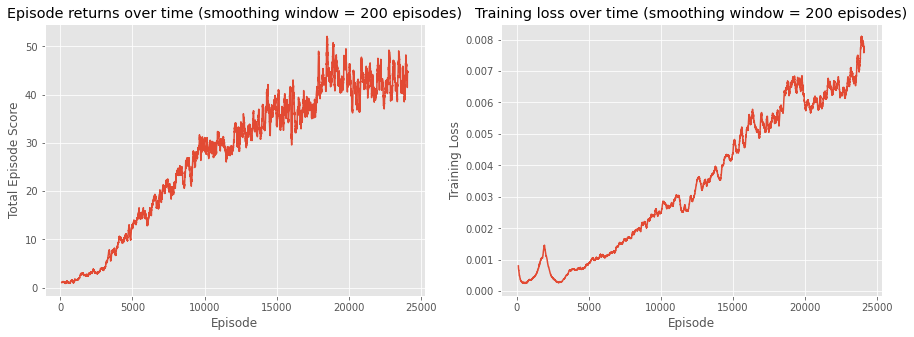

In [41]:
def plot_stats(losses, rewards):
    losses = pd.Series(all_losses).rolling(100).mean()
    rewards = pd.Series(all_rewards).rolling(100).mean()
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(rewards)
    ax1.set_title("Episode returns over time (smoothing window = 200 episodes)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total Episode Score")

    ax2.plot(losses)
    ax2.set_title("Training loss over time (smoothing window = 200 episodes)")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Training Loss")
    plt.show()

plot_stats(all_losses, all_rewards)

### Let's see the agent's behaviour

In [0]:
!apt-get install -y xvfb python-opengl x11-utils ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [0]:
from gym.wrappers import Monitor
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display_params = display.start()

In [0]:
# This function to render gym environment in colab is taken from
# https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [0]:
def show_episode(gym_env, policy, epsilon):
    env = wrap_env(gym_env)
    state = env.reset()
    state = preprocess(state)
    state = np.vstack([state] * 4)
    final_score = 0
    t = 0
    while True:
        env.render()
        action_probs = policy(torch.from_numpy(state / 255.0).float().to(device).unsqueeze(0), epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        action_reward = 0
        next_state, reward, done, info = env.step(action)
        next_state = preprocess(next_state)
        next_state = np.append(state[1:,:,:], next_state, axis=0)
        final_score += reward
        state = next_state
        t += 1
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            print("Final Score: {}".format(int(final_score)))
            break
    env.close()
    show_video()

#### Run the Agent

In [67]:
checkpoint_episode = 24340
checkpoint_name = os.path.join(os.path.join(exp_dir, "models"), "model_{}.pt".format(checkpoint_episode))

online_network = EstimatorNetwork(env).to(device)
online_network.load_state_dict(torch.load(checkpoint_name, map_location=torch.device(device)))
online_network.eval()
policy = get_epsilon_greedy_policy(online_network)
show_episode(env, policy, epsilon=0.05)

Episode finished after 899 timesteps
Final Score: 49


In [62]:
show_episode(env, policy, epsilon=0.05)

Episode finished after 922 timesteps
Final Score: 243
